### Дополнительное задание №1

<details>
  <summary>Формулировка</summary>
  
  1. **Загрузите датасет оценки качества воздуха в различных регионах**  
     Скачать [air_quality.csv](https://disk.yandex.ru/d/29AVoENYZR4NyA)
  
  2. **Подготовьте данные к обучению** - **1 балл**
     - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией.
     - В качестве целевой переменной используйте столбец `air_quality` (бинарный столбец: 0 - плохое качество воздуха, 1 - хорошее качество воздуха).
     - Создайте объекты для работы с данными в PyTorch: `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный `batch_size`.
  
  3. **Реализуйте класс нейросетевой модели для решения задачи** - **1 балл**
     - Минимальное количество `Linear` слоев в структуре - 3 штуки: входной слой, скрытый слой, выходной классификационный слой.
     - Подберите оптимальные функции активации: `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`.
     - Реализуйте логику прохождения данных по сети в методе `forward`.
     - Создайте объект модели и реализуйте перевод модели на **GPU**.
  
  4. **Напишите код цикла обучения - train-loop и валидации - eval-loop** - **1 балл**
     - В процессе обучения сохраняйте значения функции потерь на тренировочной и валидационной выборках.
  
  5. **Обучите модель и проверьте ее качество** - **1 балл**
     - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`.
     - Запустите обучение, подберите оптимальные параметры: скорость обучения и количество эпох, ориентируясь на динамику функции потерь на `train/val`.
     - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации с использованием `classification_report`.
  
  6. **Обеспечена воспроизводимость решения** - **1 балл**
     - Зафиксированы `random_state`, ноутбук воспроизводится от начала до конца без ошибок.
</details>

In [112]:
# импорт библиотек
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [113]:
# для воспроизводимости результатов
def set_seed(seed: int = 21) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(21)

Random seed set as 21


### Подготовка данных к обучению

In [114]:
# Загружаем датасет
data = pd.read_csv("../data/air_quality.csv")
data.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,air_quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,1
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,1
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,1
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,1
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,1


In [115]:
# Разделяем признаки (X) и целевую переменную (y)
X = data.drop(columns=["air_quality"])
y = data["air_quality"]

In [116]:
# значит, у нас задача бинарной классификации
y.unique()

array([1, 0])

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   air_quality                    5000 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 390.8 KB


In [118]:
data.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,air_quality
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800,0.700000
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084,0.458303
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000,0.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000,0.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000,1.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000,1.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000,1.000000


In [119]:
# Разбивка датасета на обучающую, валидационную и тестовую выборки со стратификацией (а также стандартизацией данных)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=21)

# Стандартизация: только по обучающим данным
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание Dataset и DataLoader для обучающей, валидационной и тестовой выборок
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y.values if isinstance(y, pd.Series) else y).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Создание DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Реализация базового класса 

In [120]:
# Определение нейросетевой модели
class AirQualityModel(nn.Module):
    def __init__(self, input_size):
        super(AirQualityModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    

model = AirQualityModel(X_train.shape[1])
# Переводим модель на GPU (если доступен)
if torch.backends.mps.is_available():
    device = torch.device("mps") 
    print("MPS (Metal) доступен и используется!")
else:
    device = torch.device("cpu")
    print("MPS недоступен, используется CPU")
   
# Переводим модель на устройство mps (ускорение на GPU через Metal Performance Shaders на macOS)
model = model.to(device)
model.to(device)

MPS (Metal) доступен и используется!


AirQualityModel(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Цикл обучения и валидации (Train-loop & eval-loop)

In [121]:
# train-loop
def train_model(model, num_epochs=100, eval_freq=10):
    train_loss_history, eval_loss_history = [], []
    train_f1_history, eval_f1_history = [], []
    global_step = 0

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for batch_X, target in train_dataloader:
            optimizer.zero_grad()
            log_probs = model(batch_X.to(device))
            loss = loss_function(log_probs, target.to(device))
            loss.backward()
            optimizer.step()

            preds = (log_probs >= 0.5).int().cpu().tolist()
            f1 = f1_score(preds, target.cpu().numpy().tolist())

            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1))

            if global_step % eval_freq == 0:
                val_loss, val_f1 = evaluate(model)
                eval_loss_history.append((global_step, val_loss))
                eval_f1_history.append((global_step, val_f1))
                model.train()

            global_step += 1

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            plt.figure(figsize=(15, 5))

            if train_loss_history:
                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if eval_loss_history:
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

            if train_f1_history:
                plt.subplot(122)
                plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                if eval_f1_history:
                    plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                plt.legend()

            plt.show()

    return model


# eval-loop
@torch.no_grad()
def evaluate(model, mode='eval'):
    model.eval()

    dataloader = val_dataloader if mode == 'eval' else test_dataloader

    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in dataloader:
        log_probs = model(batch_X.to(device))
        loss = loss_function(log_probs, target.to(device))
        num = log_probs.shape[0]
        loss_epoch += loss.item() * num
        num_epoch += num

        preds_list += (log_probs >= 0.5).int().cpu().tolist()
        targets_list += target.cpu().numpy().tolist()

    f1 = f1_score(preds_list, targets_list)

    return loss_epoch / num_epoch, f1


# Проверка качества модели
def test_model(model):
    test_loss, test_f1 = evaluate(model, mode='test')
    print(f"Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")

    y_true = []
    y_pred = []

    for batch_X, target in test_dataloader:
        with torch.no_grad():
            outputs = model(batch_X.to(device))
            y_true.extend(target.cpu().numpy().tolist())
            y_pred.extend((outputs >= 0.5).int().cpu().tolist())

    print(classification_report(y_true, y_pred))

### Обучение и проверка качества

  0%|          | 0/20 [00:00<?, ?it/s]

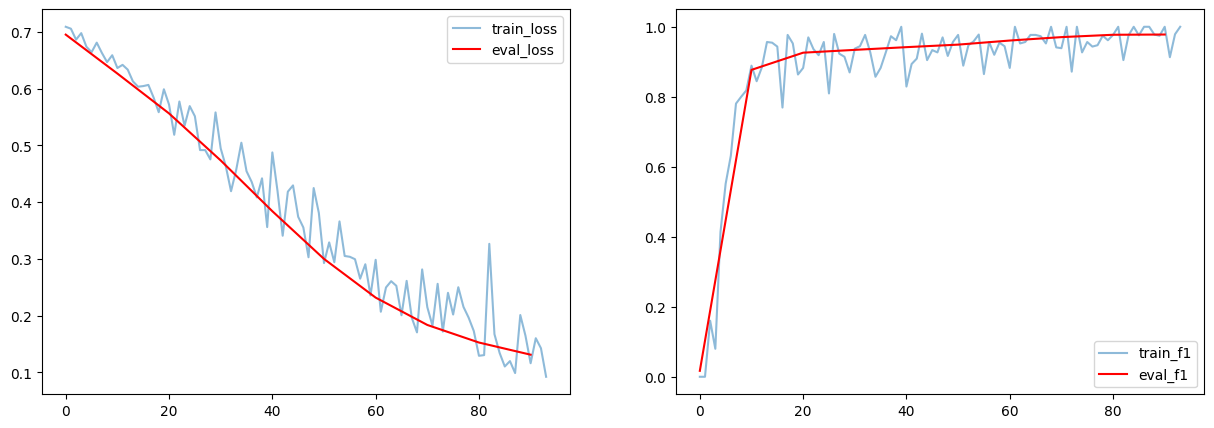

 50%|█████     | 10/20 [00:06<00:06,  1.60it/s]

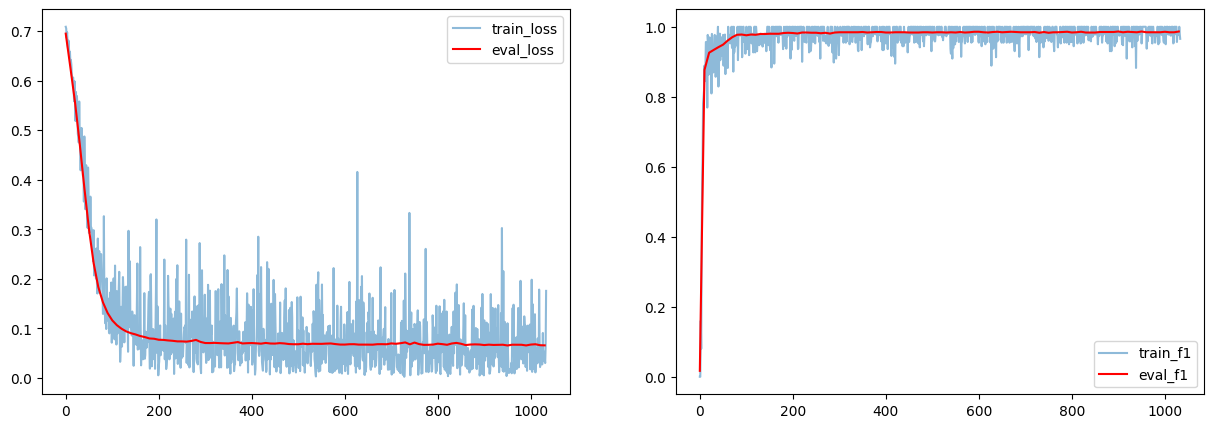

 95%|█████████▌| 19/20 [00:12<00:00,  1.59it/s]

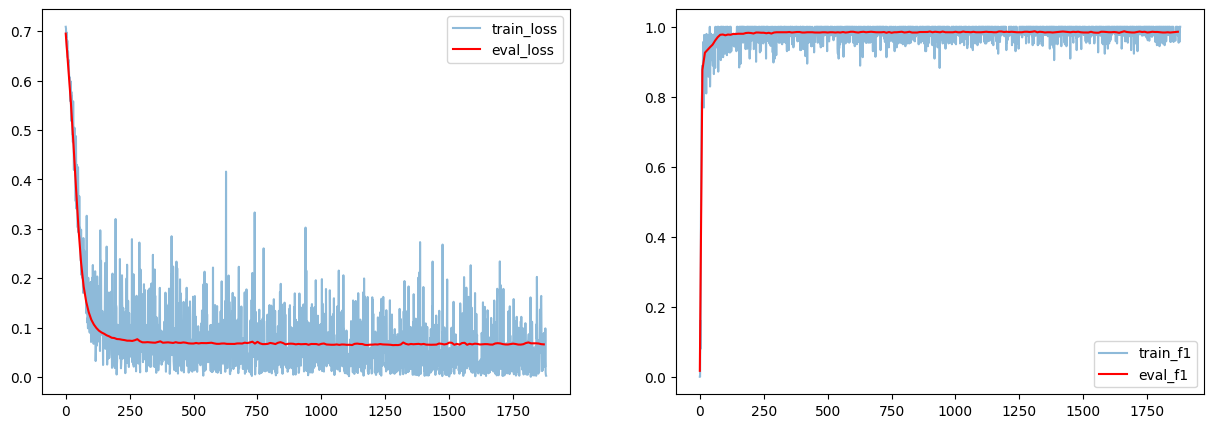

100%|██████████| 20/20 [00:13<00:00,  1.52it/s]

Test Loss: 0.0788, Test F1 Score: 0.9851
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       300
         1.0       0.98      0.99      0.99       700

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000



In [122]:
# Оптимизатор и функция потерь
loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Обучение модели
model = train_model(model, num_epochs=20, eval_freq=10)

# Проверка модели
test_model(model)

|  | **Количество эпох** | **Test Loss** | **F1 Score** | **Accuracy** | **Precision (0.0 / 1.0)** | **Recall (0.0 / 1.0)** | **F1 (0.0 / 1.0)** |
|------------------|---------------------|---------------|--------------|--------------|---------------------------|------------------------|-------------------|
| Эксперимент 1    | 15                  | 0.0788        | 0.9816       | 0.97         | 0.98 / 0.97               | 0.94 / 0.99           | 0.96 / 0.98       |
| **Эксперимент 2**    | 20                  | 0.0788        | 0.9851       | 0.98         | 0.98 / 0.98               | 0.95 / 0.99           | 0.96 / 0.99       |
| Эксперимент 3    | 100                 | 0.1306        | 0.9843       | 0.98         | 0.97 / 0.98               | 0.96 / 0.99           | 0.96 / 0.98       |